# Figure 3 - Phase dependent GCM spectra
This Jupyter notebooks reproduces Figure 3. The output .png and .pdf files are saved in <em>/figures</em>. Phase-dependent GCM spectra show the complexity that arises from their underlying 3D P-T, chemical and wind profiles.

In [33]:
%matplotlib inline
import os
import sys
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from astropy.io import fits
import pickle
import matplotlib.gridspec as gridspec
from matplotlib import colormaps
import h5py

Load 3D spectra.

In [34]:
class HayleyBeltzModel():
    def load_spectrum(fpath, trim=10):
        """Return spectrum with wav units of micron and flux units of ergs/s/cm^2/Hz"""
        wl, flux = np.loadtxt(fpath).T
        # convert wl to micron and flux to W m-2 Hz-1 to erg cm-2 s-1 Hz-1
        return wl[trim:-trim]*1e6, flux[trim:-trim]*1e3
    def trim(wl, flux, ind_low=0, ind_high=-1):
        return wl[ind_low:ind_high], flux[ind_low:ind_high]
    def get_phase(fpath):
        """Return phase of a model"""
        PH_IND = [i for i, s in enumerate(os.path.basename(fpath).split('_')) if s == 'phase'][0] + 1
        ph_degr = float(os.path.basename(fpath).split('_')[PH_IND])
        ph = ph_degr/360 # degree to relative phase
        return ph

    
def SpectrumPhaseInterpolator(wl_all, flux_all, ph_all):
    """Evaluate tellruic model for given parameters."""
    fi = RegularGridInterpolator((wl_all, ph_all), flux_all, bounds_error=False,fill_value=None, method='linear')
    def wrapped(ph, wls):
        # interpolate from telluric library
        pts = [(wl, ph) for wl in wls]
        flux_i = fi(pts)
        return wl, flux_i
    return wrapped

Create plot for the H$_2$O panel.

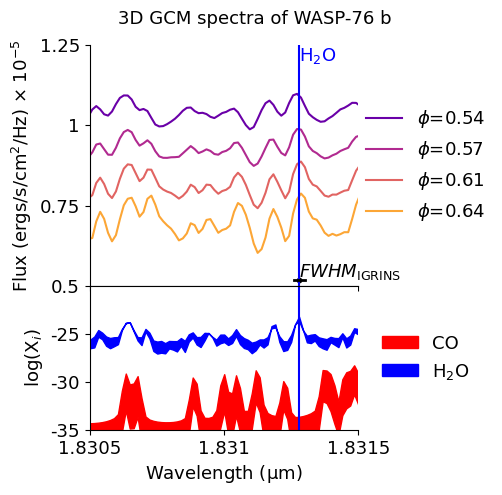

In [35]:
%matplotlib inline
dirin_models = '../data/spectra'
dirname_model = 'W76b_all_dopon/'
target = 'WASP-76 b'
dirout = f'../figures/'

cmap = colormaps['plasma']
c_list = [cmap(0.2), cmap(0.4), cmap(0.6), cmap(0.8)]

plt.close()
fig = plt.figure(figsize=(5,5.))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1.,1./1.68], width_ratios=[1.,0.15], hspace=0., left=0.17, right=0.85)
ax = fig.add_subplot(gs[0,0])
lax = fig.add_subplot(gs[0,1])

ax2 = fig.add_subplot(gs[1,0])
lax2 = fig.add_subplot(gs[1,1])

files = os.listdir(os.path.join(dirin_models, dirname_model))
nph = len(files)
ph_all = np.zeros(nph)
for n, fname_model in enumerate(files):
    f = os.path.join(dirin_models, dirname_model, fname_model)
    ph = HayleyBeltzModel.get_phase(f)
    wl, flux = HayleyBeltzModel.load_spectrum(f)
    if n ==0:
        nx = len(flux)
        flux_all = np.zeros(shape=(nx, nph))
    flux_all[:,n] = flux
    ph_all[n] = ph
wl_all = np.copy(wl)
ph_all_sorted = np.argsort(ph_all)
ph_all = ph_all[ph_all_sorted][::2]
flux_all = flux_all[:,ph_all_sorted][:,::2]
print('\n')

ax2.set_xlabel(r'Wavelength ($\rm{\mu}$m)', size=13)
ax.set_ylabel(r'Flux (ergs/s/cm$^2$/Hz) $\times$ 10$^{-5}$', size=13)

interp_spectrum_in_ph = SpectrumPhaseInterpolator(wl_all, flux_all, ph_all)

phases = np.linspace(0.54, 0.64, 4)
for ph, c in zip(phases, c_list):
    wl, flux = interp_spectrum_in_ph(wls=wl_all, ph=ph)
    ax.plot(wl,flux/1e-5, ls='-', color=c, label=r'$\phi$=' + f'{float(ph):.2f}')


files = [' ',' ']
colors = ['r', 'b']
opacities = ['CO', r'H$_2$O']
for opacity, color, file in zip(opacities, colors, files):
    iT=10
    iT2=20
    iP = 9

    if opacity == 'CO':
        x, y1, y2 = pickle.load(open('../data/opacities/fig3_CO.pkl', 'rb'))
        ax2.fill_between(x, y1, y2, label=f'{opacity}', alpha=1, color=f'{color}')
    if opacity == 'H$_2$O':
        x, y1, y2 = pickle.load(open('../data/opacities/fig3_H2O.pkl', 'rb'))
        ax2.fill_between(x, y1, y2, label=f'{opacity}', alpha=1, color=f'{color}')

ax2.set_ylabel(f'log(X$_i$)', size=13)
ax2.set_ylim(-35,-20)
xmin, xmax = 2.2945, 2.2955
xmin = 1.8305
xmax= 1.8315
ax.set_xlim(xmin, xmax)
ax2.set_xlim(xmin,xmax)


continuum_wl=2.295197
CO_wl = 2.2954152
H2O_wl = 2.294487
H2O_wl = 2.294828

H2O_wl = 1.83128
ax.axvline(CO_wl, color='r')
ax.axvline(continuum_wl, color='grey')
ax.axvline(H2O_wl, color='b')
ax2.axvline(CO_wl, color='r')
ax2.axvline(continuum_wl, color='grey')
ax2.axvline(H2O_wl, color='b')

ax.annotate(r'CO', xy=(CO_wl, 1.2), color='r')
ax.annotate(r'continuum', xy=(continuum_wl, 1.175), color='grey')
ax.annotate(r'H$_2$O', xy=(H2O_wl, 1.2), color='b', fontsize=13)

ax.spines['top'].set_visible(False) 
ax2.spines['right'].set_visible(False)
ax.spines['right'].set_visible(False)
lax.axis('off')
lax2.axis('off')


ax.set_ylim(0.5,1.25)

leg = ax.legend(bbox_to_anchor = (1.25, 0.5), facecolor='white', framealpha=1., loc='center', frameon=False, fontsize=13)
ax2.legend(bbox_to_anchor = (1.25, 0.5), facecolor='white', framealpha=1., loc='center', frameon=False, fontsize=13)

#lax2.legend(loc=1, facecolor='white', framealpha=1.)
ax2.set_yticks([-35, -30, -25])
ax2.set_xticks([1.8305, 1.831, 1.8315])
ax.set_xticks([1.8305, 1.831, 1.8315])

ax2.set_yticklabels([-35, -30, -25], size=13)
ax2.set_xticklabels([1.8305, 1.831, 1.8315], size=13)
ax.set_xticklabels(['', '', ''], size=13)

ax.set_yticks([0.5, 0.75, 1, 1.25])
ax.set_yticklabels([0.5, 0.75, 1, 1.25], size=13)

R = 45000
delta_lambda = 1./R * H2O_wl
ax.plot([H2O_wl-delta_lambda/2., H2O_wl+delta_lambda/2.], [0.52,0.52], color='k', lw=2)
ax.scatter([H2O_wl], [0.52], color='k', s=10)
ax.annotate(r'$FWHM_{\rm{IGRINS}}$', xy=(H2O_wl, 0.53), color='k',size=13)

plt.suptitle('3D GCM spectra of WASP-76 b', y=0.95, size=13)

plt.savefig(os.path.join(dirout, f'Fig3_H2O_phase_dependent_gcm_spectra.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(dirout, f'Fig3_H2O_phase_dependent_gcm_spectra.pdf'), bbox_inches='tight')
plt.show()


Create plot for the CO panel.

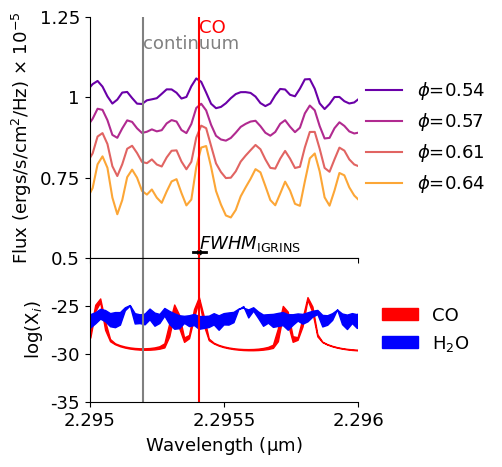

In [36]:
%matplotlib inline
cmap = colormaps['plasma']
c_list = [cmap(0.2), cmap(0.4), cmap(0.6), cmap(0.8)]

plt.close()
fig = plt.figure(figsize=(5,5.))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1.,1./1.68], width_ratios=[1.,0.15], hspace=0., left=0.17, right=0.85)
ax = fig.add_subplot(gs[0,0])
lax = fig.add_subplot(gs[0,1])

ax2 = fig.add_subplot(gs[1,0])
lax2 = fig.add_subplot(gs[1,1])

files = os.listdir(os.path.join(dirin_models, dirname_model))
nph = len(files)
ph_all = np.zeros(nph)

for n, fname_model in enumerate(files):
    f = os.path.join(dirin_models, dirname_model, fname_model)
    ph = HayleyBeltzModel.get_phase(f)
    wl, flux = HayleyBeltzModel.load_spectrum(f)
    if n ==0:
        nx = len(flux)
        flux_all = np.zeros(shape=(nx, nph))
    flux_all[:,n] = flux
    ph_all[n] = ph
wl_all = np.copy(wl)
ph_all_sorted = np.argsort(ph_all)
ph_all = ph_all[ph_all_sorted][::2]
flux_all = flux_all[:,ph_all_sorted][:,::2]
print('\n')

ax.set_ylabel(r'Flux (ergs/s/cm$^2$/Hz) $\times$ 10$^{-5}$', size=13)

interp_spectrum_in_ph = SpectrumPhaseInterpolator(wl_all, flux_all, ph_all)

phases = np.linspace(0.54, 0.64, 4)
for ph, c in zip(phases, c_list):
    wl, flux = interp_spectrum_in_ph(wls=wl_all, ph=ph)
    ax.plot(wl,flux/1e-5, ls='-', color=c, label=r'$\phi$=' + f'{float(ph):.2f}')
ax2.set_xlabel(r'Wavelength ($\rm{\mu}$m)', size=13)
ax.set_ylabel(r'Flux (ergs/s/cm$^2$/Hz) $\times$ 10$^{-5}$', size=13)


files = [' ',' ']
colors = ['r', 'b']
opacities = ['CO', r'H$_2$O']
for opacity, color, file in zip(opacities, colors, files):
    iT=10
    iT2=20
    iP = 9

    if opacity == 'CO':
        x, y1, y2 = pickle.load(open('../data/opacities/fig3_CO.pkl', 'rb'))
        ax2.fill_between(x, y1, y2, label=f'{opacity}', alpha=1, color=f'{color}')
    if opacity == 'H$_2$O':
        x, y1, y2 = pickle.load(open('../data/opacities/fig3_H2O.pkl', 'rb'))
        ax2.fill_between(x, y1, y2, label=f'{opacity}', alpha=1, color=f'{color}')

ax2.set_ylabel(f'log(X$_i$)', size=13)
ax2.set_ylim(-35,-20)
xmin, xmax = 2.295, 2.296



continuum_wl=2.295197
CO_wl = 2.2954087

H2O_wl = 1.83128
ax.axvline(CO_wl, color='r')
ax.axvline(continuum_wl, color='grey')
ax.axvline(H2O_wl, color='b')
ax2.axvline(CO_wl, color='r')
ax2.axvline(continuum_wl, color='grey')
ax2.axvline(H2O_wl, color='b')

ax.annotate(r'CO', xy=(CO_wl, 1.2), color='r', fontsize=13)
ax.annotate(r'continuum', xy=(continuum_wl, 1.15), color='grey', fontsize=13)
ax.annotate(r'H$_2$O', xy=(H2O_wl, 1.2), color='b', fontsize=13)

ax.spines['top'].set_visible(False) 
ax2.spines['right'].set_visible(False)
ax.spines['right'].set_visible(False)
lax.axis('off')
lax2.axis('off')


ax.set_ylim(0.5,1.25)

leg = ax.legend(bbox_to_anchor = (1.25, 0.5), facecolor='white', framealpha=1., loc='center', frameon=False, fontsize=13)
ax2.legend(bbox_to_anchor = (1.25, 0.5), facecolor='white', framealpha=1., loc='center', frameon=False, fontsize=13) 

ax.set_xlim(xmin, xmax)
ax2.set_xlim(xmin,xmax)

ax2.set_yticks([-35, -30, -25])
ax2.set_xticks([2.295, 2.2955, 2.296])
ax.set_xticks([2.295, 2.2955, 2.296])

ax2.set_yticklabels([-35, -30, -25], size=13)
ax2.set_xticklabels([2.295, 2.2955, 2.296], size=13)
ax.set_xticklabels(['', '', ''], size=13)

ax.set_yticks([0.5, 0.75, 1, 1.25])
ax.set_yticklabels([0.5, 0.75, 1, 1.25], size=13)

R = 45000
delta_lambda = 1./R * CO_wl
ax.plot([CO_wl-delta_lambda/2., CO_wl+delta_lambda/2.], [0.52,0.52], color='k', lw=2)
ax.scatter([CO_wl], [0.52], color='k', s=10)
ax.annotate(r'$FWHM_{\rm{IGRINS}}$', xy=(CO_wl, 0.53), color='k',size=13)


plt.savefig(os.path.join(dirout, f'Fig3_CO_phase_dependent_gcm_spectra.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(dirout, f'Fig3_CO_phase_dependent_gcm_spectra.pdf'), bbox_inches='tight')
plt.show()